# Predicting El Niño–Southern Oscillation through correlation and time series analysis/deep learning

This example uses correlation analysis and time series analysis to predict El Niño–Southern Oscillation (ENSO) based on climate variables and indices. ENSO is an irregular periodical variation in winds and sea surface temperatures over the tropical eastern Pacific Ocean.

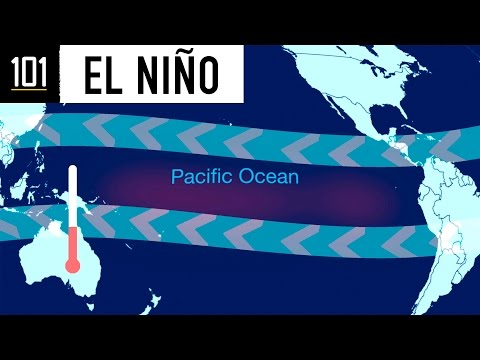

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('d6s0T0m3F8s')

ENSO can have tremendous potential impact such as droughts, floods, and tropical storms. You can look at a few story maps below to get a better understanding of the process.

In [2]:
from arcgis.gis import GIS
agol = GIS()
story_maps = agol.content.search('What El Niño Means for Southern California')[0]
story_maps

<Item title:"What El Niño Means for Southern California" type:Web Mapping Application owner:NWS.LOX_noaa>

Accurate characterization of ENSO is critical for understanding the trends. In climate science, ENSO is characterized through [Southern Oscillation Index](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/) (SOI), a standardized index based on the observed sea level pressure differences between Tahiti and Darwin, Australia. If SOI exhibits warm (greater than 0.5) or cool phase conditions for at least five consecutive values, it officially becomes an El Niño or La Niña event. Therefore, predicting SOI is the first step of ENSO forecasting. This notebooks consists of 3 sections: (1) Data exploration (2) correlation analysis; (3) Time series analysis

## Data used
The following four variables were used in this examplea as ENSO is beleived to be related to sea surface temperature, sea level pressure, precipitation, etc. 
1. Oceanic Nino Index (ONI), a climate index used for sea surface temperature (SST).
2. Eastern Tropical Pacific SST (Nino 3), another climate index used for SST focusing on a slightly different region.
3. Pacific North American Index (PNA). PNA is a closely related phenomena to ENSO.
4. Precipitation monthly mean. Historical global precipitation monthly mean in raster format.

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda update conda
conda install matplotlib
conda install scikit-learn
conda install -c conda-forge keras 
```

## Part 1. Data exploration
The first three variables along with SOI has been put into a .CSV file. To give you an overview, let's read it and look at the first few lines.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('data/enso_original.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()
print(df.head())

                 soi       oni     nino3       pna
date                                              
1979-01-01 -0.441750 -0.059963 -0.150376 -1.537109
1979-02-01  0.997371  0.056451 -0.271512 -2.725606
1979-03-01  0.072222  0.172865 -0.139364  0.080846
1979-04-01 -0.133367  0.289280  0.213033 -0.148864
1979-05-01  0.483399  0.172865  0.036835  1.269344


Let us examine how SOI changes over time.

Text(0.5,0,'Time')

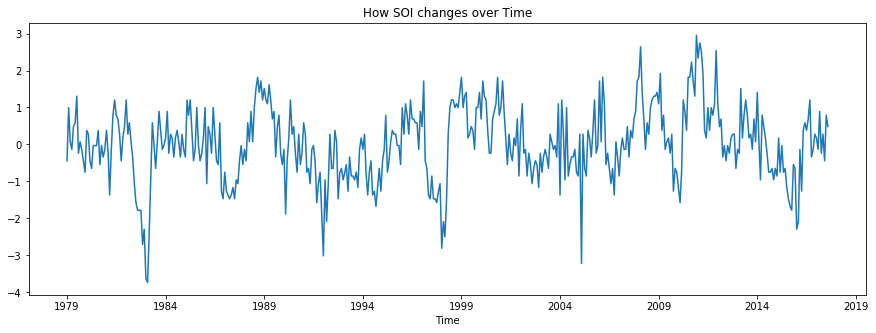

In [4]:
pyplot.figure(figsize=(15,5))
pyplot.plot(df.soi)
pyplot.title('How SOI changes over Time')
pyplot.xlabel('Time')

Let us put all four variables together and see how they are distributed or if there is any visual relationship.

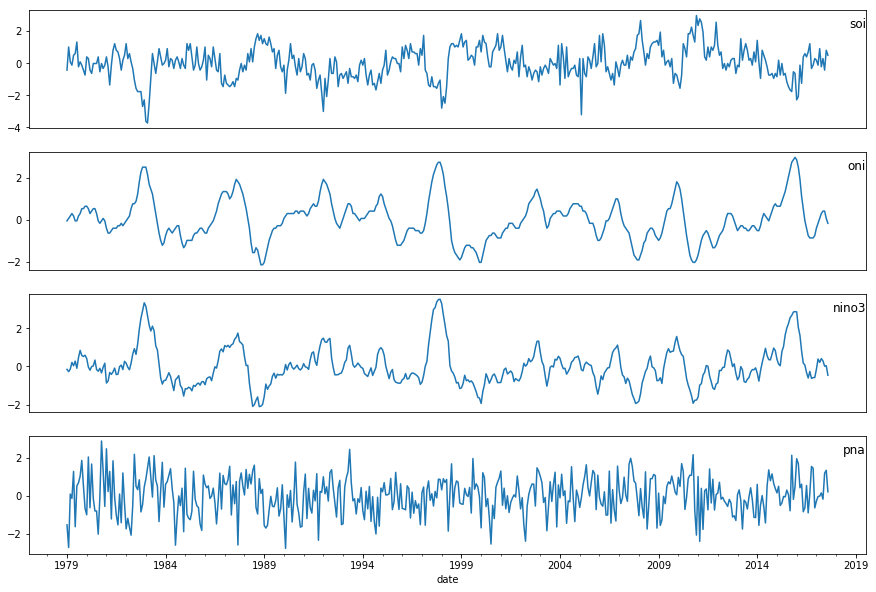

In [5]:
i = 1
fig = pyplot.figure(figsize=(15,10))
for col in df.columns.tolist():
    fig.add_subplot(len(df.columns.tolist()), 1, i)
    df[col].plot()
    pyplot.title(col, y=0.8, loc='right')
    if i != len(df.columns.tolist()):
        pyplot.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        pyplot.xlabel('')
    i += 1
pyplot.show()

As we can see, there is some relationship between the input variables (i.e., oni, nino3, pna) and output variable, soi. For example, oni and soi look highly negatively correlated. We will cover how to model SOI using these variables in the time series analysis, but first let's look at how to bring in the last variable - precipitation.

## Part 2. Correlation analysis
Global precipitation monthly mean is avaialble in raster format on ArcGIS online. In this part, we will cover how to indentify the most correlated (on time dimension) grid cell through lagged correlation analysis. There are two rationals behind this. 
1. In climate science, a phenomenon that is happening now could be a result of what has happend in the past. In other words, SOI of this month could be most correlated with the ONI of last month or the month before depending on the actual physical process.
2. ENOS is a type of teleconnection which refers to climate anomalies being related to each other at large distances.

First, let us search and acess the precipitation data from ArcGIS Online.

In [6]:
data = agol.content.search('Global Monthly Precipitation 1979-2017')[0]
data

<Item title:"Global Monthly Precipitation 1979-2017" type:Image owner:yjiang_geosaurus>

In [7]:
data_item = agol.content.get(data.id)
# data_item.download(save_path = r'data/')

Once the data is download to local, we can read it and visualize it through skimage and matplotlib to get a sense of what the data looks like. Because the spatial resolution is 2.5 by 2.5 degrees, there are 72 rows and 144 columns. The third dimension is the time dimension as the data contains monthly mean from 1970.1 to 2017.10, which is 466 months in total.

(72, 144, 466)


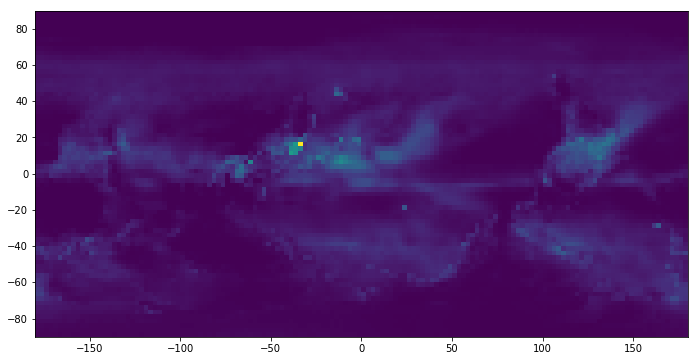

In [8]:
from skimage import io
import math
from scipy.stats.stats import pearsonr
from numpy import unravel_index

precip_full = io.imread('data/precipitation.tif')
precip_full = np.flip(precip_full, 0)

# print the dimension of the precip_full, (lat, lon, time)
print(precip_full.shape)
# let's print out the first month/band of this data
pyplot.figure(figsize=(15,6))
pyplot.imshow(precip_full[:,:,0], extent=[-180, +180, -90, 90])

Before calculating the correlation, let's transform the precipitation monthly mean to precipitation anomaly, which a usually provides better signal than absolute precipitation. For short, anomaly means how much precipitation departs from what is normal for that time of year at a specific location. Let's say, we would like to know the anomaly of a specific grid in October this year. We need to compute the historial mean of October precipitation and then caculate its difference with value of this October.

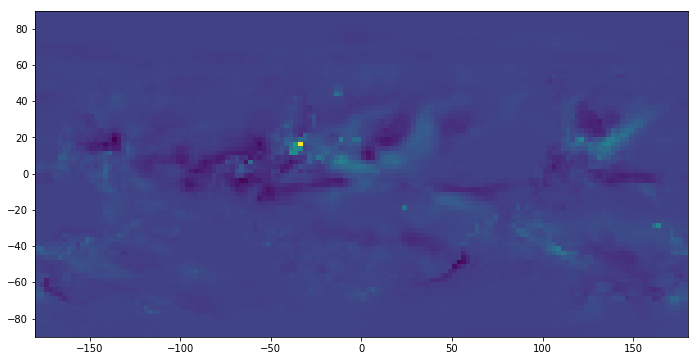

In [9]:
# calculate the historical mean for each month
a = np.zeros(shape = (precip_full.shape[0], precip_full.shape[1], math.ceil(precip_full.shape[2]/12)*12))
a[:,:,0:precip_full.shape[2]] = precip_full
a = a.reshape(a.shape[0], a.shape[1], int(a.shape[2]/12), 12)
monthly_sum = np.sum(a, axis=2)

montly_mean_1_10 = monthly_sum[:,:,0:10]/a.shape[2]
montly_mean_11_12 = monthly_sum[:,:,-2:]/(a.shape[2] - 1)
monthly_mean = np.append(montly_mean_1_10, montly_mean_11_12, axis=2)

# calculate the difference
for i in range(a.shape[3]):
    a[:,:,i,:] -=monthly_mean

# reshape the data back to its orginial dimension
a = a.reshape(a.shape[0], a.shape[1], a.shape[2]*a.shape[3])

# visualize the first month anomaly
pyplot.figure(figsize=(15,6))
pyplot.imshow(a[:,:,0], extent=[-180, +180, -90, 90])

Now we have the anomaly. Let us calculate Pearson correlation coefficient between SOI and precipitation anomaly across all the grids based on a range of time lag from 0 to 5. The goal is the find the grid that has the greatest absolute Pearson correlation.

In [10]:
df.shape

(464, 4)

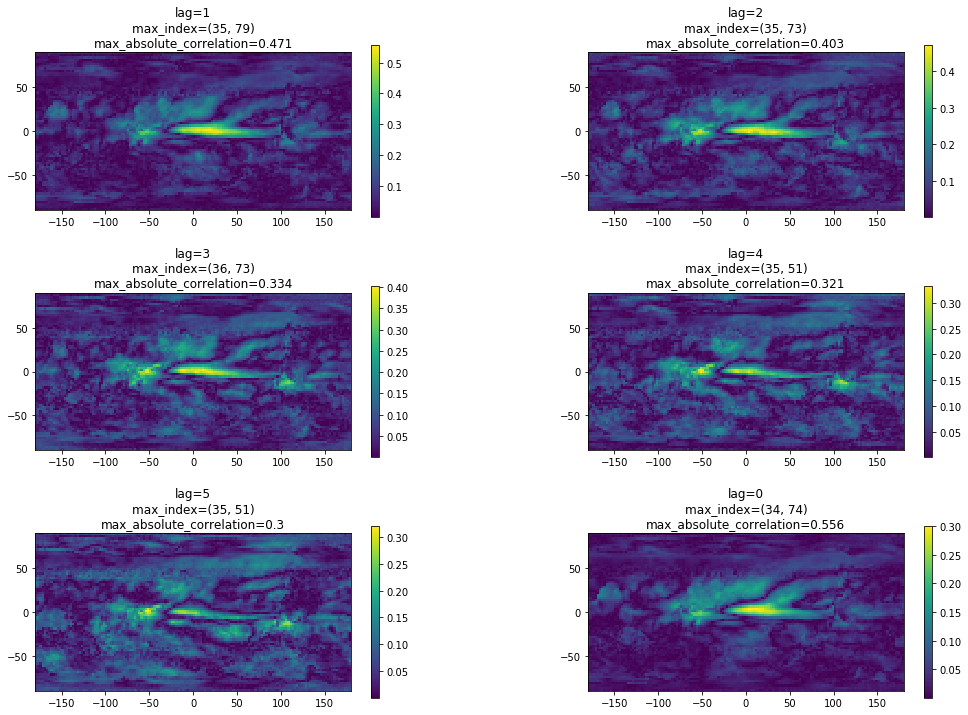

In [11]:
lag = 5
fig, axs = pyplot.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.4, wspace=0.4)

for t in range(lag+1):
    soi = df.values[t:,0]
    soi = soi.reshape(soi.shape[0], 1)

    precip = a[:,:,0:-4-t]
    
    r2 = []
    for i in range(precip.shape[0]):
        for j in range(precip.shape[1]):
            r2_index = pearsonr(soi, precip[i,j,:].reshape(precip.shape[2], 1))[0]
            r2.append(r2_index)

    r2_map = np.array(r2).reshape(precip.shape[0], precip.shape[1])
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)

    im = axs.flat[t-1].imshow(np.abs(r2_map), extent=[-180, +180, -90, 90])
    fig.colorbar(im, ax = axs[t//2, t%2])
    
    # we only care only absolute correlation in this case
    r2_map = np.abs(r2_map)
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)
    axs.flat[t-1].set_title('lag=' + str(t) + '\n' + 'max_index=' + str(max_index) + '\n' + 'max_absolute_correlation=' + str(float("%.3f" % r2_map[max_index])))


As can be seen, the largest correlation results from lag=0 at (row, column) = (34, 74). We will then take the precipitation anomaly of this grid and combine it with the other variables to predict SOI in another notebook.

## Part 3. Time Series Analysis/LSTM

The third part of ENSO prediction focuses on time seris analysis. Here our SOI time series prediction problem is formulated as a regression problem and the idea is to use prior time steps to predict the next time step(s). Specifically, this analysis consists of three sections:
1. Data cleanup and transformation: transform the raw data into format that supervised machine learning algorithms can take, and split out training and test datasets
2. Model training: train a [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) neural network.
3. Prediction and evaluation: evaluate the models on test dataset and plot the results.

## Data cleanup and transformation

Time series data can be phrased as supervised learning if we think of by previous time steps as input variables and the next time step(s) as the output variable. Before we do any transformationm, let's first import all the necessary packages and take a look at what our data looks like.

In [2]:
%matplotlib inline
import os.path
import warnings
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
warnings.filterwarnings('ignore')

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('data/enso_ready.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.head()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,soi,oni,nino3,pna,precip
date,,,,,
1951-01-01,1.5,-0.8,-0.72,-1.18,NaN
1951-02-01,0.9,-0.5,-0.43,-2.11,NaN
1951-03-01,-0.1,-0.2,-0.63,-1.09,NaN
1951-04-01,-0.3,0.2,0.00,0.47,NaN
1951-05-01,-0.7,0.4,-0.12,1.19,NaN


As precipitation data is not available until 1979, let's remove the first few rows, standardize each column by calcuting the z-score, and move soi (input variable) to the last column of the table.

In [3]:
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]
df.head()

,oni,nino3,pna,precip,soi
date,,,,,
1979-01-01,-0.059963,-0.150376,-1.537109,1.424196,-0.441750
1979-02-01,0.056451,-0.271512,-2.725606,0.200227,0.997371
1979-03-01,0.172865,-0.139364,0.080846,-0.530831,0.072222
1979-04-01,0.289280,0.213033,-0.148864,-0.755133,-0.133367
1979-05-01,0.172865,0.036835,1.269344,-0.270530,0.483399


Most supervised learning algorithms require all input variables to be on the same row with its corresponding output variable. In SOI prediction, the goal is to use the variables (i.e., oni, nino3, pna, precip, and soi) of the previous time steps (e.g. 12) to predict the SOI of the next time steps (e.g. 3). Formally, the use of prior time steps to predict the next time step is called the sliding window approach (aka window or lag method) in time series analysis/prediction. Therefore, let's define a method that transforms panda time series into format that supervised learning algorithms can take.

In [4]:
"""
This method takes a time series and returns transformed data.
data: time series as pandas dataframe
n_in: number of previous time steps as input (X)
n_out: number of next time steps as output (y)
dropnan: whether or not to drop rows with NaN values
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,-1])
        if i == 0:
            names += ['VAR(t)']
        else:
            names += ['VAR(t+%d)' % i]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Note that after transformation, there are some edges cases where the input or output variable could be NaN. For example, as data before 1979 is not available, there is no way to form a row for SOI of 1979. That's why there is a dropnan option is the method.

In [5]:
# specify the size of our sliding window and number of features
enso = df.values.astype('float32')
lag = 12
ahead = 3
n_features = 1
reframed = series_to_supervised(enso, lag, ahead)
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),VAR(t),VAR(t+1),VAR(t+2)
12,-0.059963,-0.150376,-1.537109,1.424196,-0.441750,0.056451,-0.271512,-2.725606,0.200227,0.997371,...,0.061769,-0.441750,0.638523,0.587453,-0.678194,-0.032382,-0.750133,0.380605,0.277811,-0.441750
13,0.056451,-0.271512,-2.725606,0.200227,0.997371,0.172865,-0.139364,0.080846,-0.530831,0.072222,...,-0.032382,-0.750133,0.638523,0.411255,-1.007778,-0.076689,0.380605,0.277811,-0.441750,-0.647339
14,0.172865,-0.139364,0.080846,-0.530831,0.072222,0.289280,0.213033,-0.148864,-0.755133,-0.133367,...,-0.076689,0.380605,0.522109,-0.029240,2.028384,-0.804978,0.277811,-0.441750,-0.647339,-0.030572
15,0.289280,0.213033,-0.148864,-0.755133,-0.133367,0.172865,0.036835,1.269344,-0.270530,0.483399,...,-0.804978,0.277811,0.289280,-0.194425,-0.638245,0.269456,-0.441750,-0.647339,-0.030572,-0.030572
16,0.172865,0.036835,1.269344,-0.270530,0.483399,-0.059963,0.279107,-1.636982,-0.068382,0.586194,...,0.269456,-0.441750,0.405694,-0.007215,1.658851,-0.359143,-0.647339,-0.030572,-0.030572,-0.030572


## Model training

Now we have the data, let's define a method that trains a LSTM model. For the purpose of simplicity, we define a two layer neural network with one LSTM layer and one dense layer.

In [6]:
"""
This method takes training data and returns a LSTM model
train: training data
n_lag: number of previous time steps
n_ahead: number of next time steps
nb_epoch: number of epochs
n_neurons: number of n_neurons in the first layer
"""
def fit_lstm(train, n_lag, n_ahead, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, :-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], n_lag, int(X.shape[1]/n_lag))

    # design neural network architecture. This is a simple LSTM just for demo purpose
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(n_ahead))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit the NN
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
        model.reset_states()
    return model

Let's split our transformed data into training and test sets and feed the model training method. The first 80 precent will be used for training purpose and the last 20 percent will be using as test set. Note that in time sereis analysis, we don't do random shuffle because it's important to preserve time dependency/order.

In [7]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# fit a LSTM model with the transformed data
# model fitting can be very time-consuming, therefore a pre-trained model is included in the data folder
file_path = 'data/my_model.h5'
if not os.path.exists(file_path):
    model = fit_lstm(train, lag, ahead, 1, 30, 30)
    model.save(file_path)
else:
    model = load_model(file_path)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 30)                   4320      
_________________________________________________________________
dense_4 (Dense)              (1, 3)                    93        
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________


## Prediction and evaluation

Now let's apply the model to the test set and evaluate the accuracy for each of those three next time steps.

In [9]:
# predict the SOI values for next three time steps given a single input sample 
def forecast_lstm(model, X, n_batch, n_lag):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, n_lag, int(len(X)/n_lag))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# make prediciton for a list of input samples
def make_forecasts(model, n_batch, train, test, n_lag, n_ahead):
    forecasts = list()
    for i in range(len(test)):
        X = test[i, :-n_ahead]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch, n_lag)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [10]:
forecasts = make_forecasts(model, 1, train, test, lag, ahead)
# pring out the output for the first input sample
forecasts[0]

[-1.5042609, -1.4436339, -1.52989]

As mentioned in the very beginning, time series prediction is treated as a regression problem in our case, so let's compute mean square error (MSE) for each next time step.

In [11]:
def evaluate_forecasts(y, forecasts, n_lag, n_seq):
    print('Evaluation results (RMSE) for each next tim step:')
    for i in range(n_seq):
        actual = [row[i] for row in y]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d time step: %f' % ((i+1), rmse))
        
# evaluate forecasts
actual = [row[-ahead:] for row in test]
evaluate_forecasts(actual, forecasts, lag, ahead)

Evaluation results (RMSE) for each next tim step:
t+1 time step: 0.795490
t+2 time step: 0.843505
t+3 time step: 0.907717


To to a better understanding of the prediction result, let's plot it out and compare with with the original data.

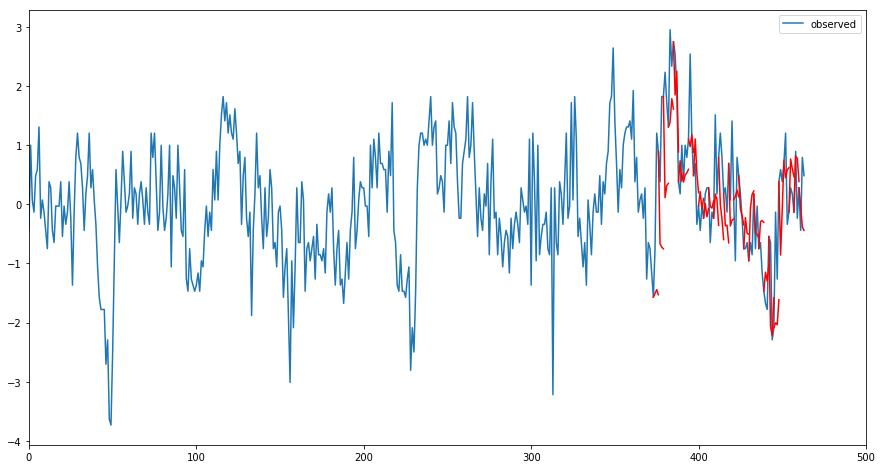

In [12]:
# plot the forecasts in the context of the original dataset, multiple segments
def plot_forecasts(series, forecasts, n_test, xlim, ylim, n_ahead, linestyle = None):
    pyplot.figure(figsize=(15,8))
    if linestyle==None:
        pyplot.plot(series, label='observed')
    else:
        pyplot.plot(series, linestyle, label='observed')
    pyplot.xlim(xlim, ylim)
    pyplot.legend(loc='upper right')
    # plot the forecasts in red
    for i in range(len(forecasts)):
        # this ensures not all segements are plotted, it is plotted every n_ahead
        if i%n_ahead ==0:
               off_s = len(series) - n_test + 2 + i - 1
               off_e = off_s + len(forecasts[i]) + 1
               xaxis = [x for x in range(off_s, off_e)]
               yaxis = [series[off_s]] + forecasts[i] 
               pyplot.plot(xaxis, yaxis, 'r')
    pyplot.show()
    
plot_forecasts(df['soi'].values, forecasts, test.shape[0] + ahead - 1, 0, 500, ahead)

Here the blue line is the ogriginal time series, the red line is the prediction results. As we can see, it is doing a reasonable job. ENSO prediction is considered one of the most difficult task in climate science, but with more sophisicated modeling tuning and architecture desgin, we believe better results could be achieved.

## Conclusion

In this notebook, we observed how ENSO prediction can be done with the aid of ArcGIS API for Python. We started with a correlation to find the most correlated grid in terms of precipitation. And then we performed time series analysis and LSTM to predict SOI based a few input variables including precipitation from prior time steps. With a basic LSTM example, we are able to acheive a reasonable accuracy as ENSO prediction is one of the most challenge tasks in climatology.